In [1]:
import numpy as np
import deepdish as dd
import pandas as pd
from brian2.only import second
import matplotlib.pyplot as plt
import seaborn as sns

from sweep import get_script
from grid_criticality import analysis_path, path_pr

import plot_utils as pu

In [2]:
delta_p = pd.read_csv(f'{analysis_path}/criticality_data.csv', index_col=0)
ioi = 976
poi = delta_p.loc[ioi, 'p_inh']
roi = delta_p.loc[ioi, 'r_inh']
runseed = delta_p.loc[ioi, 'runseed']
net = delta_p.loc[ioi, 'net']

In [3]:
script, path = get_script(f'lif_alpha_beta_1_different_net_seed_0_pinh_{path_pr(poi)}_rinh_{path_pr(roi)}_runseed_{runseed}')

spike_stats = dd.io.load(f'{path}/spike_stats_12ms.h5')
t_spike = np.array(spike_stats['time'])/3600

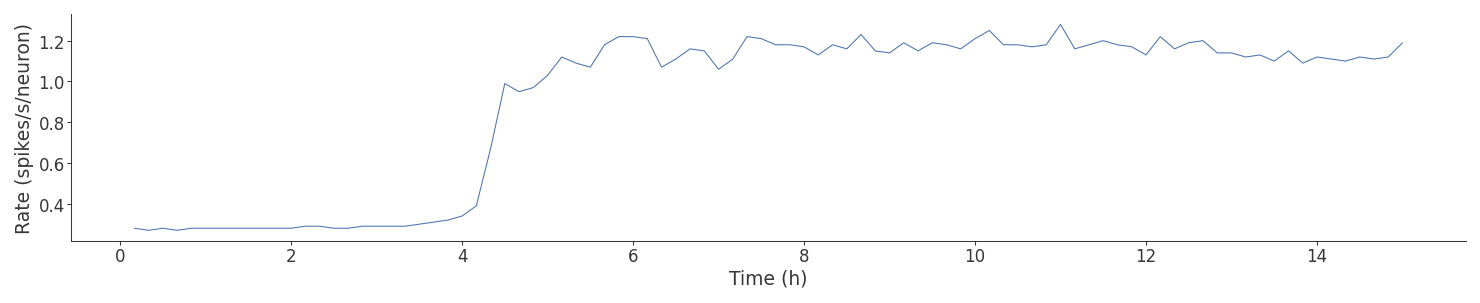

In [4]:
def plot_rate(ax):
    ax.plot(t_spike, spike_stats['median'][net]['all'], zorder=1)
    ax.set_xlabel('Time (h)')
    ax.set_ylabel('Rate (spikes/s/neuron)')
    sns.despine(ax=ax)

fig, ax = plt.subplots(figsize=(12,2), dpi=150)
plot_rate(ax)

In [5]:
def get_netspikes(iteration, tmin, tmax):
    N, N_nets = script.params['N'], script.params['N_nets']
    inh_ratio = script.params.get('inhibitory_ratio', 0.2)
    N_exc = int(N*(1-inh_ratio))
    N_inh = N - N_exc
    elo, ilo = net*N_exc, N_nets*N_exc + net*N_inh
    ehi, ihi = elo + N_exc, ilo + N_inh
    
    spikes = dd.io.load(f'{path}/spikes_{iteration}.h5')

    # First filter: Net
    emask = (spikes['i'] >= elo) & (spikes['i'] < ehi)
    imask = (spikes['i'] >= ilo) & (spikes['i'] < ihi)
    mask = emask | imask

    spike_i = spikes['i'][mask]
    spike_t = spikes['t'][mask]

    # Adjust indices
    spike_i[spike_i < ehi] -= elo
    spike_i[spike_i >= ilo] -= ilo - N_exc

    # Second filter: Time
    tmask = (spike_t >= tmin) & (spike_t < tmax)
    
    return spike_i[tmask], spike_t[tmask] - tmin

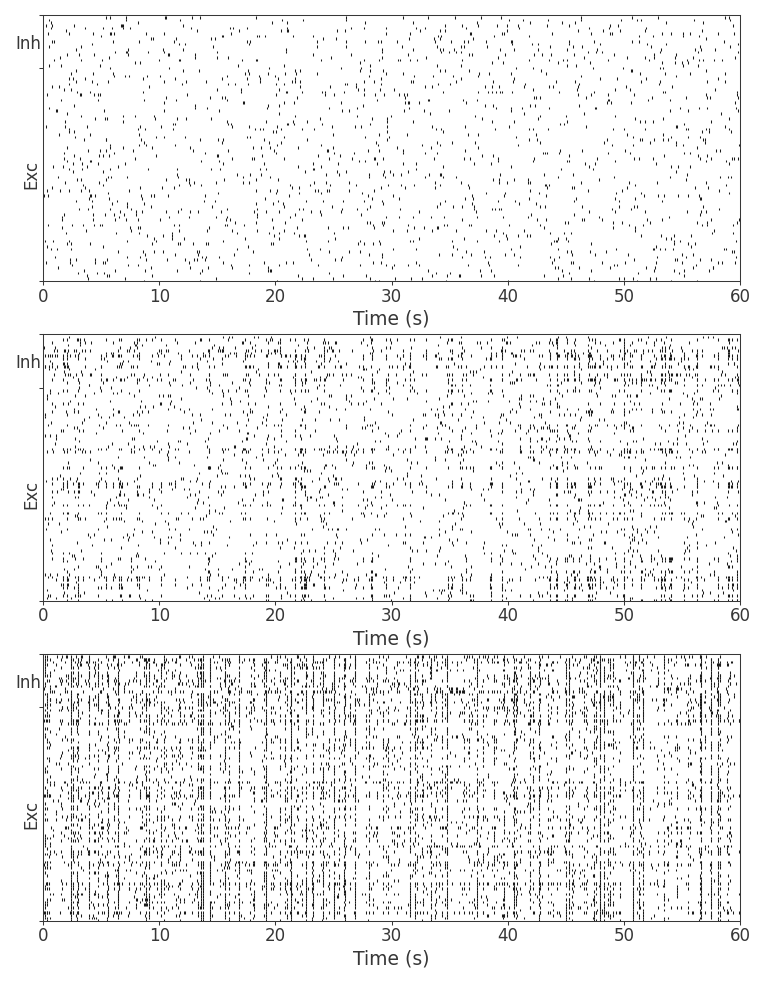

In [6]:
def plot_raster(ax, t_hours, duration=20*second):
    t0 = (t_hours*script.runtime - duration)/script.runtime
    iteration = int(t0)
    iter_t0 = (t0 % 1) * script.runtime/second
    spike_i, spike_t = get_netspikes(iteration, iter_t0, iter_t0+duration/second)
    ax.vlines(spike_t, spike_i-.5, spike_i+.5, lw=.5, color='k')
    ax.tick_params(axis='y', which='minor', length=0)
    ax.set_yticks([40, 90], ['Exc', 'Inh'], minor=True, rotation=90, va='center')
    ax.set_yticks([0,80,100], ['','',''])

    ax.set_xlabel('Time (s)')
    ax.set_ylim(0,100)
    ax.set_xlim(0, duration/second)

fig, axs = plt.subplots(3, figsize=(6,8), dpi=150)
for ax, hours in zip(axs, (1, 4.3, 15)):
    plot_raster(ax, hours, 60*second)

In [7]:
W_stats = dd.io.load(f'{path}/W_stats2.h5')
t_weights = W_stats['time'] / 3600  # to hours

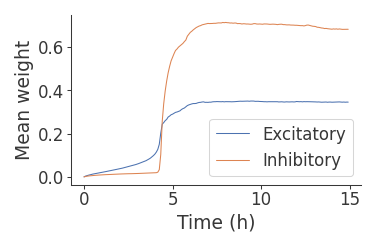

In [8]:
def plot_weights(ax):
    wE = np.nanmean([w[:80, :] for w in W_stats['matrix'][net]], axis=(1,2))
    ax.plot(t_weights, wE, label='Excitatory')
    wI = np.nanmean([w[80:, :] for w in W_stats['matrix'][net]], axis=(1,2))
    ax.plot(t_weights, wI, label='Inhibitory')
    ax.legend()
    ax.set_xlabel('Time (h)')
    ax.set_ylabel('Mean weight')
    sns.despine(ax=ax)
fig, ax = plt.subplots(figsize=(2.5,1.5), dpi=150, facecolor='w')
plot_weights(ax)

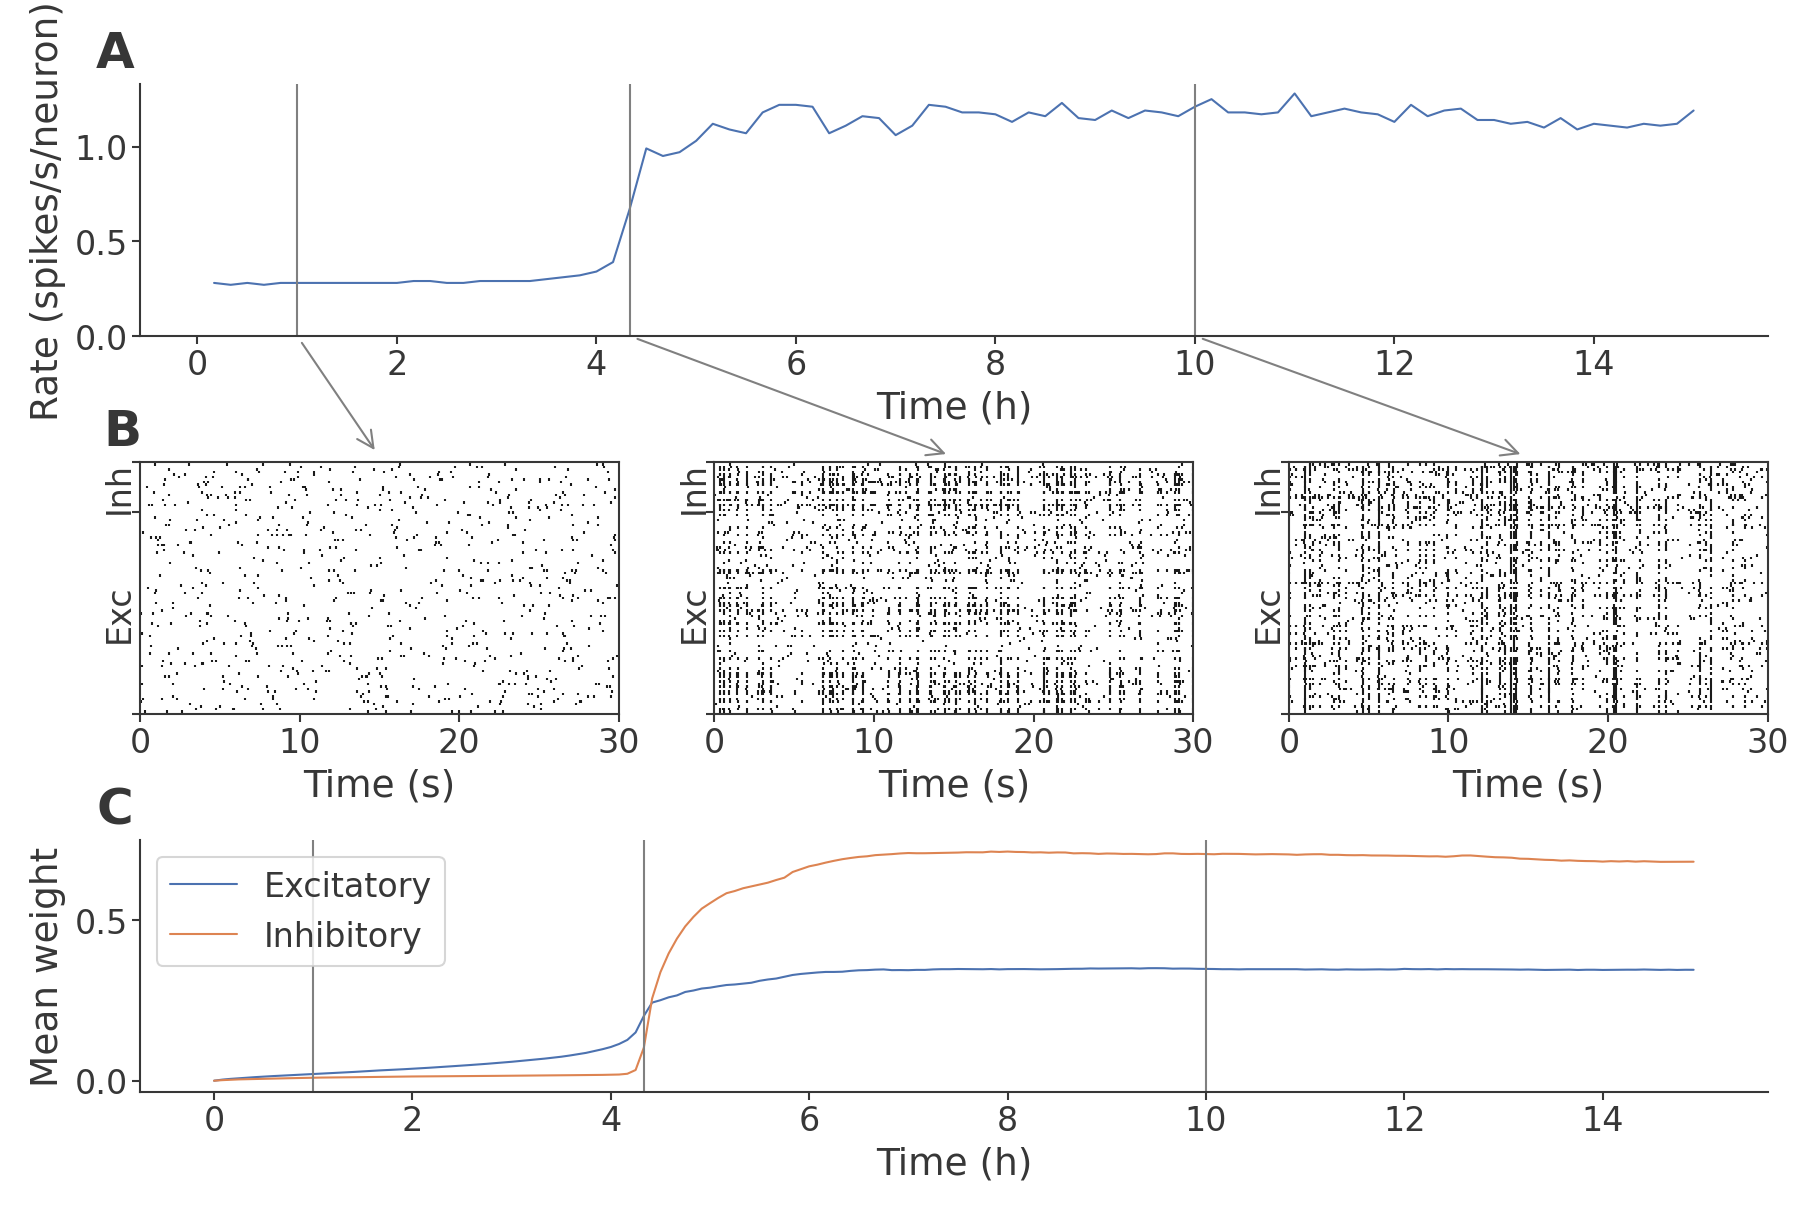

In [9]:
fig = plt.figure(figsize=pu.fullwidth(4), dpi=300, facecolor='w')
gs = fig.add_gridspec(3,3, hspace=.5)

ax_rate = fig.add_subplot(gs[0, :])
plot_rate(ax_rate)
pu.label_panel(ax_rate, 0, left=.4)
ax_rate.set_ylim(bottom=0)

ax_weights = fig.add_subplot(gs[2, :])
plot_weights(ax_weights)
pu.label_panel(ax_weights, 2, left=.4)

axs = [fig.add_subplot(gs[1,i]) for i in range(3)]
for ax, hours in zip(axs, (1, 4.333, 10)):
    plot_raster(ax, hours, 30*second)
    ax_rate.axvline(hours, color='grey')
    ax_weights.axvline(hours, color='grey')
    a = ax.annotate('', xy=(hours, 0), xycoords=ax_rate.transData, xytext=(0.5,1.02), textcoords='axes fraction', arrowprops=dict(arrowstyle="<-", ec='grey'))
pu.label_panel(axs[0], 1)

plt.savefig('Figure 3.tif', bbox_inches='tight')